# Dask setup

<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo">

System-wide installation:
``` bash
sudo -H python3 -m pip install --upgrade "dask[complete]"
```
On both the client, the scheduler and the workers (be careful to use the same versions)

[Dask](https://dask.org/) documentation.

Then run `dask-scheduler` on the server scheduler and `dask-worker` on the server workers:
![dask-scheduler-worker.png](dask-scheduler-worker.png)

# Initialise and connect the client to the server

In [1]:
from dask.distributed import Client, progress
client = Client('tcp://10.31.210.110:8786')
client

Client Scheduler: tcp://10.31.210.110:8786 Dashboard: http://10.31.210.110:8787/status,Cluster Workers: 1 Cores: 32 Memory: 135.15 GB


# Dask delayed functions for GATE

In [2]:
from dask import delayed
import subprocess         # to run Gate
import SimpleITK as sitk  # to merge output .mhd images
import numpy as np

In [3]:
@delayed
def get_gate_app(git_repo, gate_work):
    subprocess.run(['git', 'clone', git_repo, gate_work])
    return gate_work

@delayed
def run_gate(gate_work, model, parameters, job_id):
    # parameters
    if 'particle' in parameters:
        # Gate -a [Source_ID,95][particle,gamma][energy,1][nb,1e5][job,1] mac/main_AF.mac
        source_id = parameters['source_id']
        particle = parameters['particle']
        energy = parameters['energy']
        nb = parameters['primaries_n']
        params = f'-a [Source_ID,{source_id}][particle,{particle}][energy,{energy}][nb,{nb}][job,{job_id}]'
    else:
        # Gate -a [Source_ID,95][nb,1e5][job,1] mac/main_AF.mac
        source_id = parameters['source_id']
        nb = parameters['primaries_n']
        params = f'-a [Source_ID,{source_id}][nb,{nb}][job,{job_id}]'
    # log filename
    logfile = gate_work + f'output/{job_id}_{model}-log.txt'
    
    # open a logfile to save stdout and stderr
    with open(logfile, 'w') as f:
        subprocess.run(['Gate', params, f'mac/main_{model}.mac'], cwd=gate_work, 
                       stdout=f, stderr=subprocess.STDOUT)
    return job_id

@delayed
def merge_dose(gate_work, model, jobs):
    for i,job_id in enumerate(jobs):
        dose_img = sitk.ReadImage(gate_work + f'output/{job_id}_{model}-model-Dose.mhd')
        if (i == 0):
            dose_arr = sitk.GetArrayFromImage(dose_img)
        else:
            dose_arr += sitk.GetArrayFromImage(dose_img)
    dose_merged = sitk.GetImageFromArray(dose_arr)
    # save image as mhd
    dose_merged.CopyInformation(dose_img)
    sitk.WriteImage(dose_merged, gate_work + f'output/{model}-model-Dose_merged.mhd')
    return 1

@delayed
def merge_dose_std(gate_work, model, jobs, primaries_n):
    for i,job_id in enumerate(jobs):
        dose_img = sitk.ReadImage(gate_work + f'output/{job_id}_{model}-model-Dose.mhd')
        dose2_img = sitk.ReadImage(gate_work + f'output/{job_id}_{model}-model-Dose-Squared.mhd')
        if (i == 0):
            dose_arr = sitk.GetArrayFromImage(dose_img)
            dose2_arr = sitk.GetArrayFromImage(dose2_img)
        else:
            dose_arr += sitk.GetArrayFromImage(dose_img)
            dose2_arr += sitk.GetArrayFromImage(dose2_img)
    n = primaries_n * len(jobs)
    # calculate the absolute uncertainties
    dose_std_arr = np.sqrt((dose2_arr*n - dose_arr**2)/(n-1))
    # make it relative and handle the zeros
    dose_std_arr = np.divide(dose_std_arr, dose_arr, out=np.ones_like(dose_arr), where=(dose_arr!=0))
    dose_std_merged = sitk.GetImageFromArray(dose_std_arr)
    # save image as mhd
    dose_std_merged.CopyInformation(dose_img)
    sitk.WriteImage(dose_std_merged, gate_work + f'output/{model}-model-Dose-Uncertainty_merged.mhd')
    return 1

@delayed
def merge_outputs(dose, dose_std):
    return 1

# Define the application and simulations to run

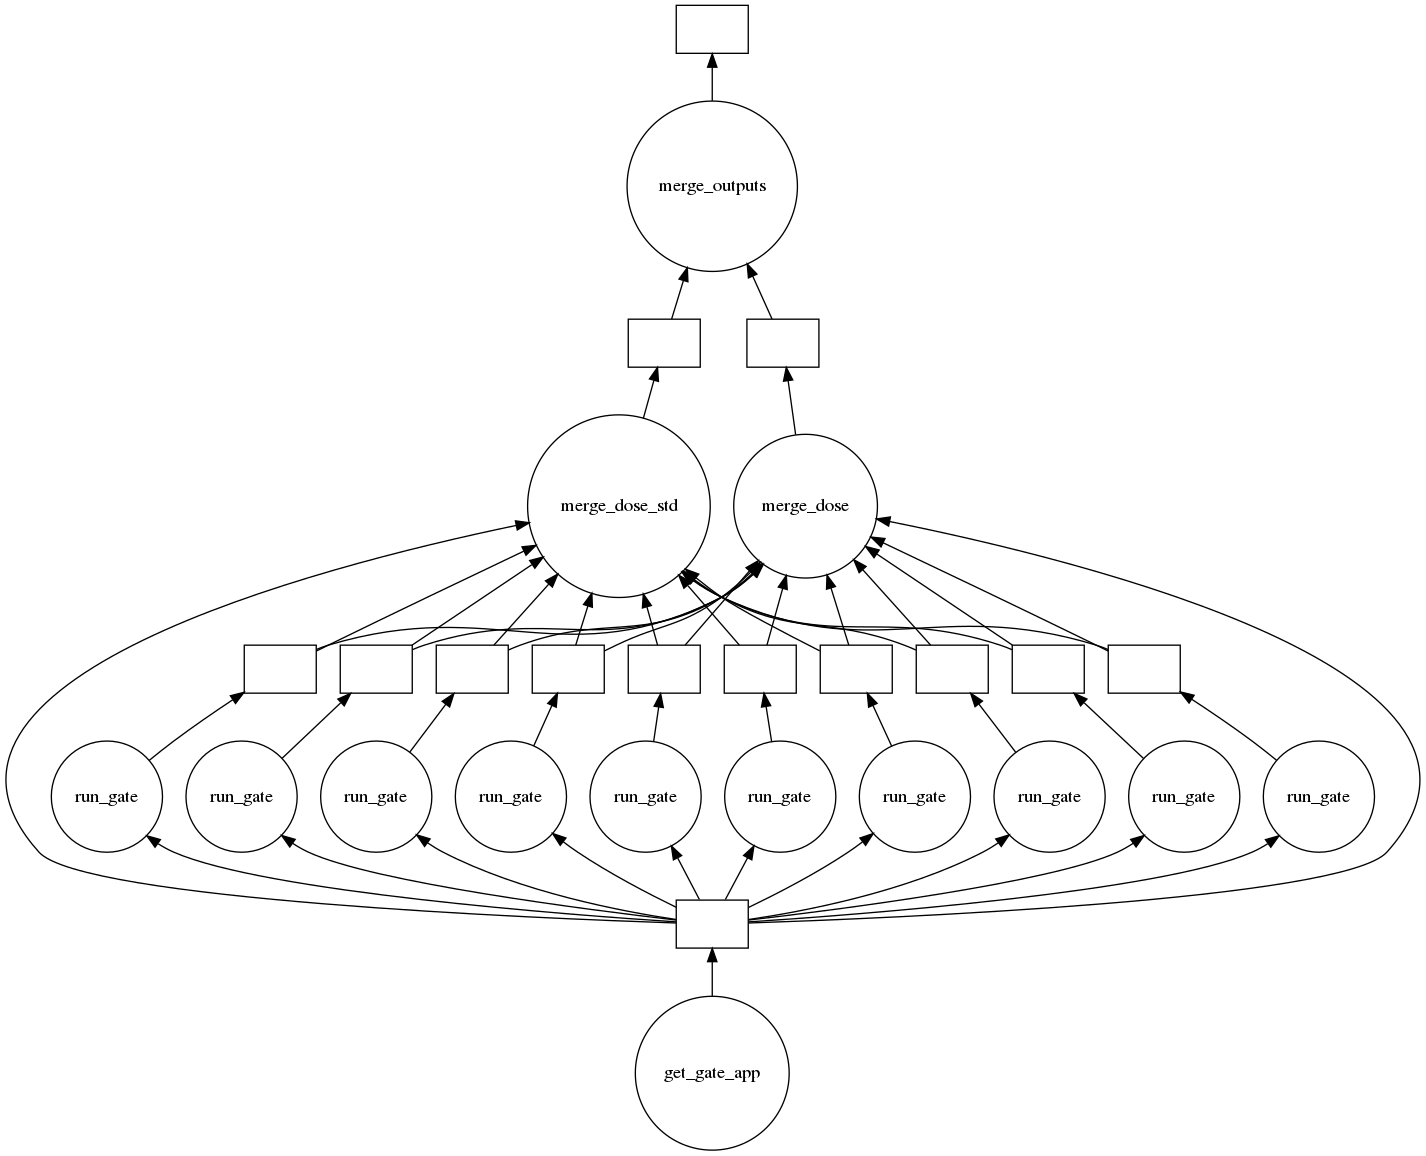

In [4]:
# simulation parameters
gate_work = '/home/maxime/dask/gate_work/'
model = 'AF'
params = {'source_id': 95, 'particle': 'gamma', 'energy': 1, 'primaries_n': 1e2}
# params = {'source_id'=95, 'primaries_n'=1e6}
jobs_n = 10

# download the Gate application via git clone and define the gate_work directory
gate_work = get_gate_app('https://github.com/MCvin/Gate_ICRP110_dosi.git', gate_work)

# simulation jobs
jobs = []
for job_id in range(jobs_n):
    job = run_gate(gate_work, model, params, job_id)
    jobs.append(job)

# merge jobs outputs
dose = merge_dose(gate_work, model, jobs)
dose_std = merge_dose_std(gate_work, model, jobs, params['primaries_n'])
simu = merge_outputs(dose, dose_std)

# show dask simulation graph
simu.visualize()

# Run the simulations in the background

In [5]:
futures = simu.persist()

# Get the results

In [6]:
results = futures.compute()
results

1